In [10]:
# https://blog.keras.io/building-autoencoders-in-keras.html

import os
import sys
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard


In [14]:
# adds the gaussian noise based on the mean and the standard deviation 
def add_gaussian_noise(data):
  mean = (10, 10, 10)
  std = (50, 50, 50)
  row, col, channel = data.shape
  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')
  return data + noise
  
def add_gaussian_to_dataset(data):
  count = 0
  end = len(data)
  output_data = []
  while count < end:
    output_data.append(add_gaussian_noise(data[count]))
    # output_data.append(add_gaussian_blur(data[count]))
    count+=1
  return np.array(output_data)

def add_gaussian_blur(data):
    dst = cv2.GaussianBlur(data, (35, 35), cv2.BORDER_DEFAULT)
    return dst

In [15]:
image_dir = 'dataAE/images'
sys.path.append(image_dir)

images = os.listdir(image_dir)
print(images)


['8.jpg', '9.jpg', '14.jpg', '28.jpg', '15.jpg', '17.jpg', '16.jpg', '12.jpg', '13.jpg', '11.jpg', '10.jpg', '21.jpg', '20.jpg', '22.jpg', '23.jpg', '27.jpg', '26.jpg', '18.jpg', '24.jpg', '25.jpg', '19.jpg', '4.jpg', '5.jpg', '7.jpg', '6.jpg', '2.jpg', '3.jpg', '1.jpg']


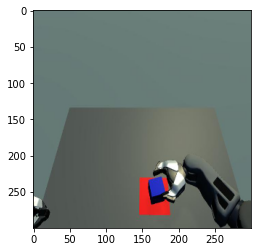

In [18]:
# create tensor batch of images
height = 300#480
width = 300#640

image_batch = []
for rgb in images:
  image = plt.imread(os.path.join(image_dir, rgb))
  image = cv2.resize(image, (width, height))
  # image = image / 255.0
  

  image_batch.append(image)
  

# stack images onto new channel
# image_batch = tf.stack(image_batch)
# print(image_batch.shape)
# print(type(image_batch))


plt.imshow(image_batch[3])


In [53]:
# resize the images
# image_batch = tf.image.resize(
#   image_batch, (320,320), method='nearest', preserve_aspect_ratio=False,
#   antialias=True, name=None)
  
# print(image_batch.shape)
# plt.imshow(image_batch[1,:])

In [20]:

# image_batch = image_batch/ 255

# #split test and train dataset
# ##USE SKLEARN  from sklearn.model_selection import train_test_split -- see mask-rcnn method
# train_ds, test_ds = tf.split(image_batch, num_or_size_splits=2, axis=0)
# tf.shape(train_ds).numpy()


ds = tf.stack(image_batch)
print(ds.shape)


(28, 300, 300, 3)


In [21]:

train_ds = ds[1:25,:]
test_ds = ds[25:,:]

print(train_ds.shape, test_ds.shape)



(24, 300, 300, 3) (3, 300, 300, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(24, 300, 300, 3)


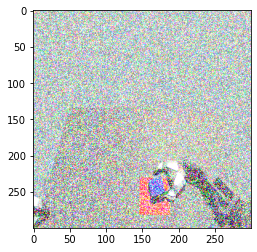

In [24]:
gaussian_train_ds = add_gaussian_to_dataset(train_ds)
gaussian_test_ds = add_gaussian_to_dataset(test_ds)

plt.imshow(gaussian_train_ds[2,:])
print(gaussian_train_ds.shape)



In [57]:
# rescaled data

# train_ds = train_ds.astype('float32') / 255.0
# test_ds = test_ds.astype('float32')  / 255.0

train_ds = train_ds / 255
test_ds = test_ds / 255

# # reduce images
gaussian_train_ds = gaussian_train_ds / 255.0 
gaussian_test_ds = gaussian_test_ds / 255.0



In [58]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(width, height, 3)) 
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [59]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])



In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [26]:
gaussian_auto_encoder = create_model()
# gaussian_early_stop = EarlyStopping(monitor='loss', patience=3)
gaussian_history = gaussian_auto_encoder.fit(gaussian_train_ds,
                                            train_ds, 
                                            epochs=50, 
                                            batch_size=8,
                                            shuffle=True,
                                            validation_data=(gaussian_test_ds, test_ds),
                                            callbacks=[TensorBoard(log_dir='/tmp/autoencoder', histogram_freq=0, write_graph=False)])
                                            #, gaussian_early_stop])

# save model
gaussian_auto_encoder.save('model')


Epoch 1/50
3/3 [==============================] - 6s 2s/step - loss: 0.0244 - val_loss: 0.0158
Epoch 2/50
3/3 [==============================] - 6s 2s/step - loss: 0.0241 - val_loss: 0.0158
Epoch 3/50
3/3 [==============================] - 6s 2s/step - loss: 0.0235 - val_loss: 0.0156
Epoch 4/50
3/3 [==============================] - 6s 2s/step - loss: 0.0237 - val_loss: 0.0156
Epoch 5/50
3/3 [==============================] - 6s 2s/step - loss: 0.0232 - val_loss: 0.0155
Epoch 6/50
3/3 [==============================] - 6s 2s/step - loss: 0.0229 - val_loss: 0.0155
Epoch 7/50
3/3 [==============================] - 6s 2s/step - loss: 0.0228 - val_loss: 0.0154
Epoch 8/50
3/3 [==============================] - 6s 2s/step - loss: 0.0225 - val_loss: 0.0154
Epoch 9/50
3/3 [==============================] - 6s 2s/step - loss: 0.0224 - val_loss: 0.0153
Epoch 10/50
3/3 [==============================] - 6s 2s/step - loss: 0.0222 - val_loss: 0.0152
Epoch 11/50
3/3 [==============================] 

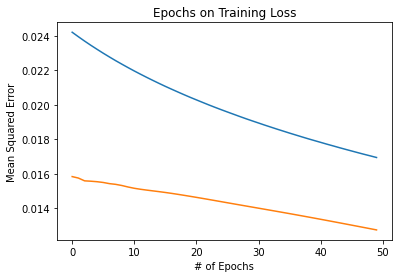

In [27]:
plt.plot(gaussian_history.epoch, gaussian_history.history['loss'])
plt.plot(gaussian_history.epoch, gaussian_history.history['val_loss'])
plt.title('Epochs on Training Loss')
plt.xlabel('# of Epochs')
plt.ylabel('Mean Squared Error')
plt.show()



In [1]:
# evaluate the model on the test set

result = gaussian_auto_encoder.predict(gaussian_test_ds) #test_ds
gaussian_auto_encoder.evaluate(test_ds, gaussian_test_ds)


NameError: name 'gaussian_auto_encoder' is not defined

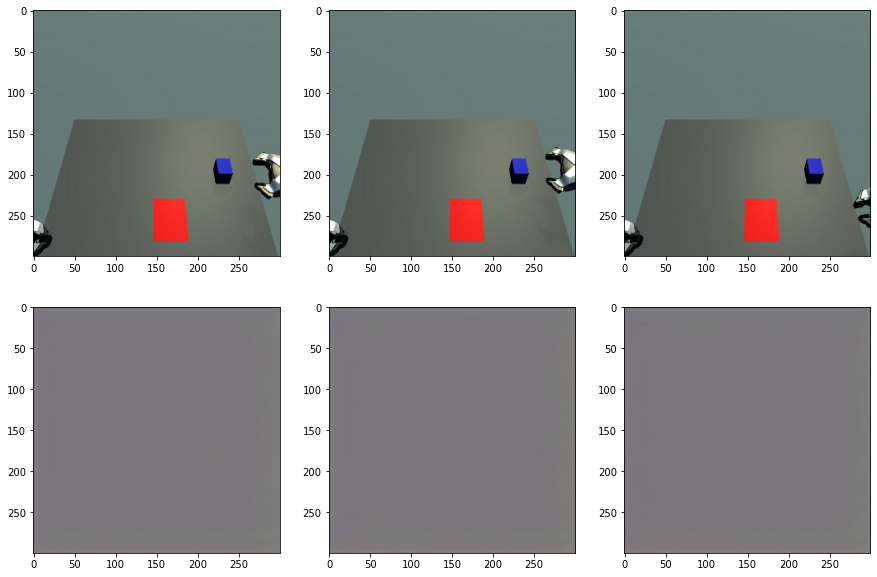

In [29]:
n = 3
plt.figure(figsize=(15,10))
for idx in range(0,n):
    ax = plt.subplot(2,n,idx+1)
    plt.imshow(test_ds[idx])
    ax = plt.subplot(2,n,idx+1+n)
    plt.imshow(result[idx])

plt.show()

In [30]:
# ! tensorboard --logdir=/tmp/autoencoder --bind_all  --port 6000 